<a href="https://colab.research.google.com/github/anajikadam/Clinical-Trial-Search-Engine/blob/main/ClinicalTextClassification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mtsamples.csv to mtsamples.csv


In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1
    word_count = len(vocab.keys())
    return sent_count,word_count

In [ ]:
data_path = "/content/mtsamples.csv"
clinical_text_df = pd.read_csv(data_path)

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count, word_count = get_sentence_word_count(clinical_text_df['transcription'].tolist())

print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [ ]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


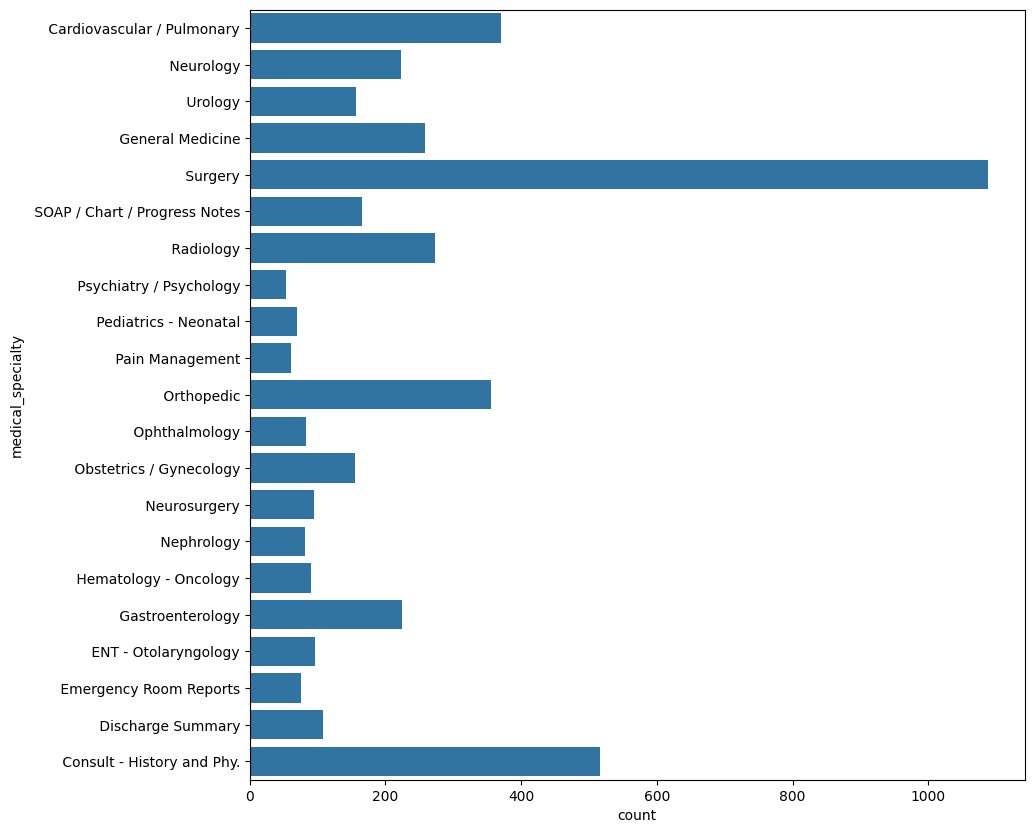

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [ ]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.reset_index(drop=True, inplace=True)
df = data.copy()
data.shape

(4597, 2)

In [ ]:
# data[data['transcription'].str.startswith('2-D M-MODE')]

In [ ]:
print('Sample Transcription 1--->>>     '+data.iloc[5]['transcription']+'\n')
# print('Sample Transcription 125--->>>     '+data.iloc[125]['transcription']+'\n')
# print('Sample Transcription 1000--->>>     '+data.iloc[1000]['transcription'])

Sample Transcription 1--->>>     CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETO

In [ ]:
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = ''.join([w for w in text if not w.isdigit()])

    # Replace specified symbols with a space
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;:]')
    text = REPLACE_BY_SPACE_RE.sub(' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub('\s+', ' ', text).strip()
    return text


def lemmatize_text(text):
    """
    This function lemmatizes the words in the first and the second-to-last sentences of the input text.

    Parameters:
    text (str): The input text to be lemmatized.

    Returns:
    str: A string containing the lemmatized words from the first and the second-to-last sentences of the input text.
    """
    lemmatizer = WordNetLemmatizer()
    wordlist = []

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Get the first and the second-to-last sentences and last sentence
    initial_sentences = sentences[:1]
    final_sentences = sentences[-2:-1]

    # Lemmatize words in the initial sentences
    for sentence in initial_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))

    # Lemmatize words in the final sentences
    for sentence in final_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))

    # Join the lemmatized words into a single string
    return ' '.join(wordlist)

In [ ]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [ ]:
print('Sample Transcription 1--->>>     '+data.iloc[5]['transcription']+'\n')

Sample Transcription 1--->>>     cc confusion and slurred speech hx primarily obtained from boyfriend this yo rhf experienced a flulike illness week prior to presentation obgyn exam including cervical biopsy and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix



In [ ]:
idx = 5
print("Original Sentence: \n", sent_tokenize(data.iloc[idx]['transcription']))
print("\nwe take only first and last sentence: ")
ls = sent_tokenize(data.iloc[idx]['transcription'])[:1] + sent_tokenize(data.iloc[idx]['transcription'])[-2:]
print("after filter Sentence: \n",\
      ls)

Original Sentence: 
 ['cc confusion and slurred speech hx primarily obtained from boyfriend this yo rhf experienced a flulike illness week prior to presentation obgyn exam including cervical biopsy and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix']

we take only first and last sentence: 
after filter Sentence: 
 ['cc confusion and slurred speech hx primarily obtained from boyfriend this yo rhf experienced a flulike illness week prior to presentation obgyn exam including cervical biopsy and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix', 'cc confusion and slurred speech hx primarily obtained from boyfriend this yo rhf experienced a flulike illness week prior to presentation obgyn exam including cervical biopsy and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix']


Tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

Explanations for each parameter of `TfidfVectorizer`:

- **analyzer='word'**: Specifies that the feature extraction should be done at the word level.
- **stop_words='english'**: Removes common English stop words from the text before processing.
- **ngram_range=(1,3)**: Considers unigrams, bigrams, and trigrams (sequences of 1, 2, and 3 words) as features.
- **max_df=0.75**: Ignores terms that appear in more than 75% of the documents, assuming they are too common to be useful.
- **use_idf=True**: Enables the use of inverse document frequency (IDF) for weighting the features.
- **smooth_idf=True**: Adds one to the document frequencies to avoid division by zero when calculating IDF.
- **max_features=1000**: Limits the number of features (terms) to the top 1000 based on term frequency across the corpus.

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word',
                             stop_words='english',
                             ngram_range=(1,3),
                             max_df=0.75,
                             use_idf=True,
                             smooth_idf=True,
                             max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_nam())
print(feature_names)


['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blood loss', 'blood loss cc', 'blood loss minimal', 'blood loss ml', '

Lets visualize the tf-idf features using t-sne plot.
<!--
For more on t-sne check here: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding  -->
T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. The t-sne plot shows that lot of categories are overlapping with each other.

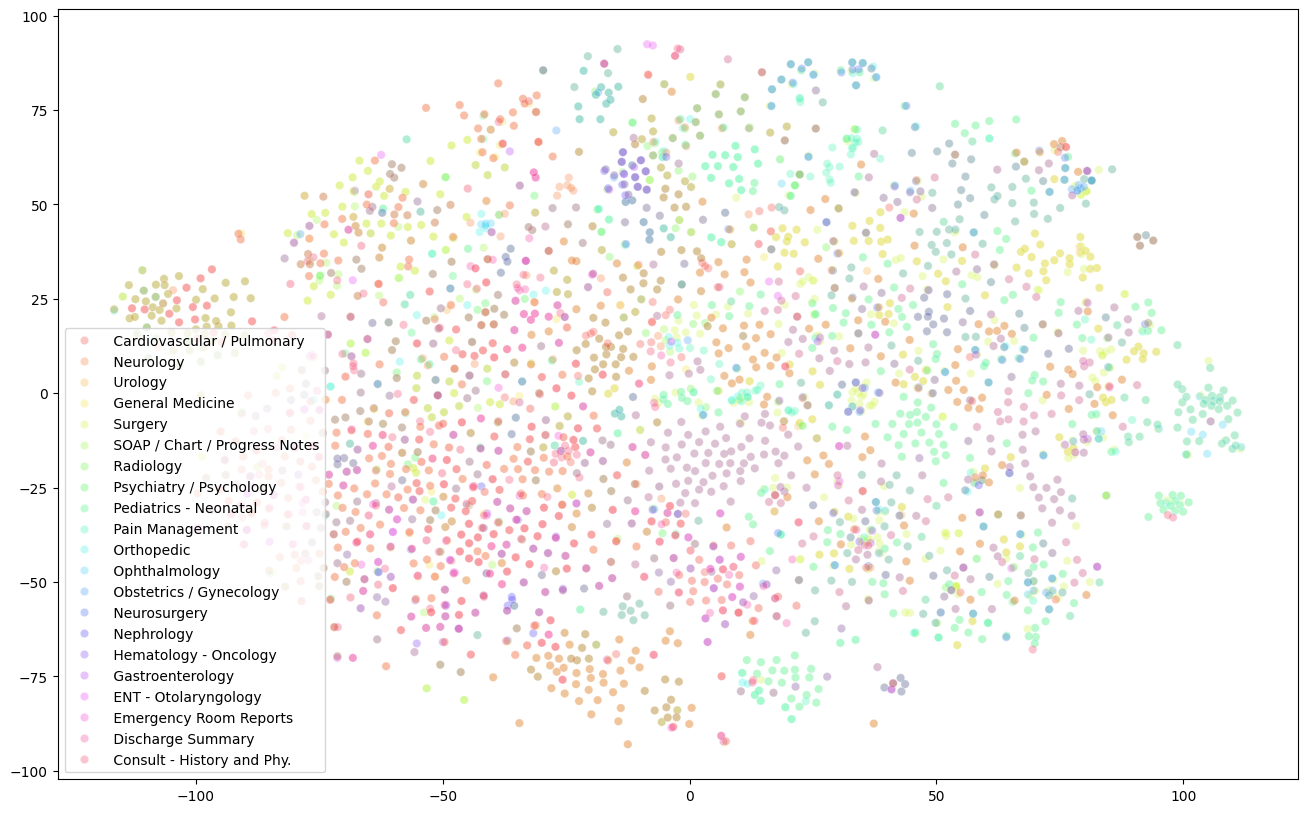

In [ ]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()

# Assuming tfIdfMatrix is your input matrix
tfIdfMatrix_array = np.asarray(tfIdfMatrix)

tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix_array)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

# PCA
Let us do PCA to reduce dimensionality of features.

PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

In [ ]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

In [ ]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3447, 587)
Test_Set_Size:(1150, 587)


# Logisitic Regression

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet',
                         solver= 'saga',
                         l1_ratio=0.5,
                         random_state=1)
clf.fit(X_train, y_train)

y_test_pred= clf.predict(X_test)

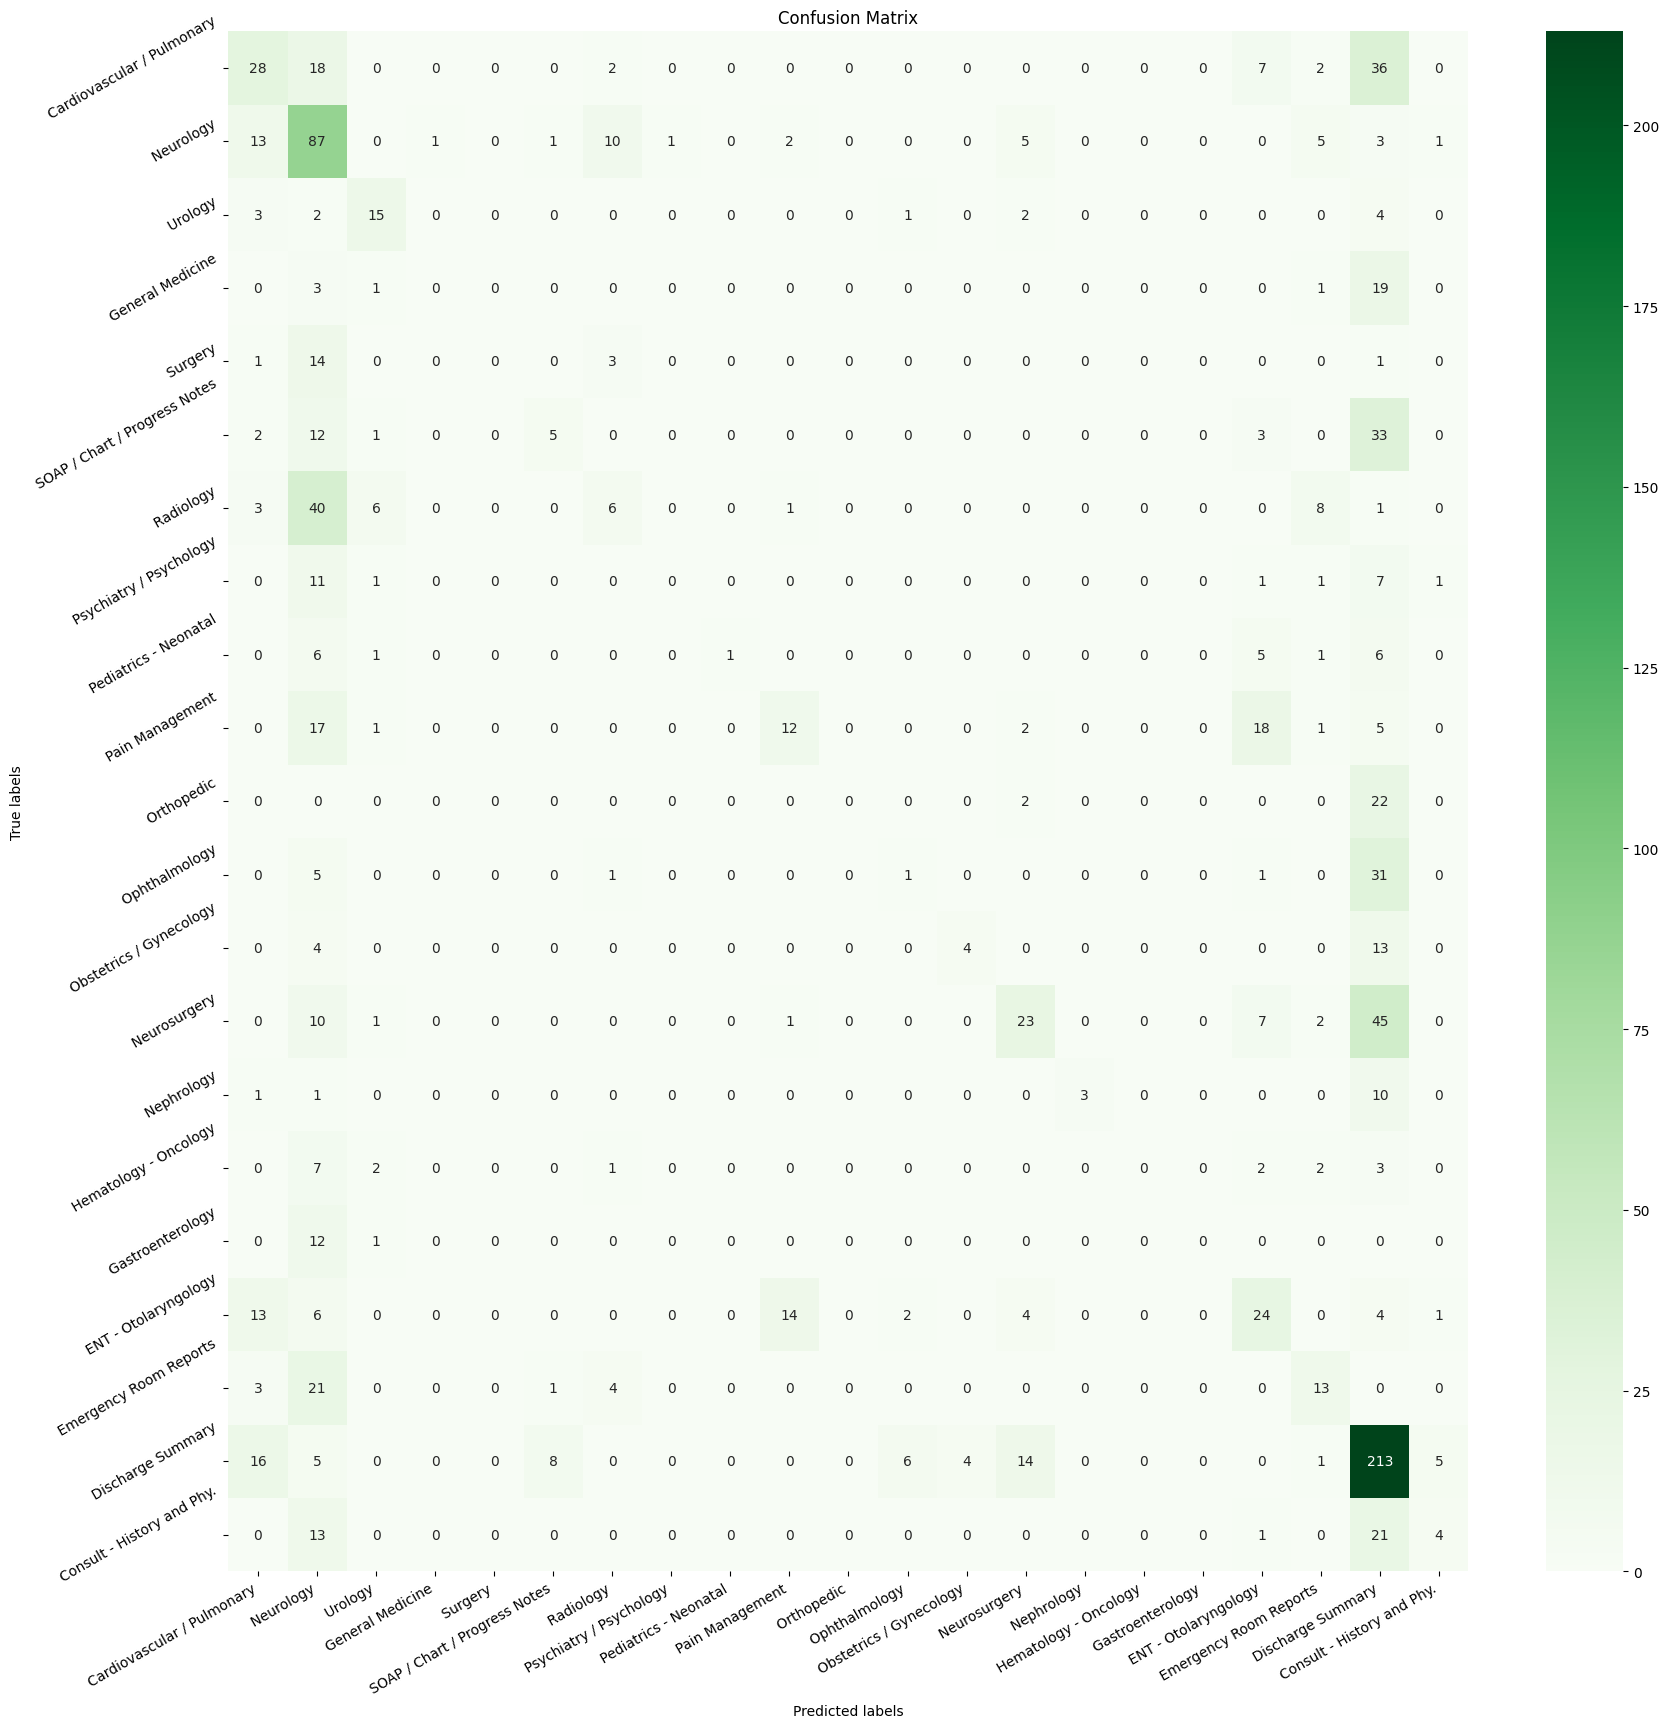

In [ ]:
labels = category_list

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a figure
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

# Plot heatmap
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Rotate tick labels
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Show the plot
plt.show()

In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.34      0.30      0.32        93
                     Neurology       0.40      0.21      0.28        56
                       Urology       0.33      0.10      0.16        39
              General Medicine       0.22      0.09      0.13        65
                       Surgery       0.45      0.78      0.57       272
 SOAP / Chart / Progress Notes       0.35      0.31      0.33        42
                     Radiology       0.35      0.35      0.35        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       1.00      0.20      0.33        15
                    Orthopedic       0.44      0.26      0.33        89
                 Ophthalmology       0.50      0.19      0.28        21
       Obstetrics / Gynecology       0.10      0.03      0.04  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are quite poor.

Let us apply some domain knowledge and see if we can improve the results The surgey category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc. Similarly other categories like Emergency Room Reports, Discharge Summary, Notes also overlap with specialities. Hence i remove them.

In [ ]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 Consult - History and Phy. : 516
Cat:3 Discharge Summary : 108
Cat:4 ENT - Otolaryngology : 96
Cat:5 Emergency Room Reports : 75
Cat:6 Gastroenterology : 224
Cat:7 General Medicine : 259
Cat:8 Hematology - Oncology : 90
Cat:9 Nephrology : 81
Cat:10 Neurology : 223
Cat:11 Neurosurgery : 94
Cat:12 Obstetrics / Gynecology : 155
Cat:13 Ophthalmology : 83
Cat:14 Orthopedic : 355
Cat:15 Pain Management : 61
Cat:16 Pediatrics - Neonatal : 70
Cat:17 Psychiatry / Psychology : 53
Cat:18 Radiology : 273
Cat:19 SOAP / Chart / Progress Notes : 166
Cat:20 Urology : 156
============Reduced Categories======================


(2324, 2)

Let us use sciscpacy models to detect medical entities in our text scispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text.

https://allenai.github.io/scispacy/

In [ ]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bionlp13cg_md-0.5.4.tar.gz

In [ ]:
import scispacy
import spacy
import en_ner_bionlp13cg_md

# Load the NLP model
nlp = en_ner_bionlp13cg_md.load()

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [ ]:
print('Sample Transcription 1--->>>   '+data.iloc[5]['transcription']+'\n')

Sample Transcription 1--->>>   CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.

In [ ]:
# Function to process text and extract named entities
def process_text(text):
    wordlist = []
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)


 pre-process data using scispacy to detect medical entities in transcriptions

In [ ]:
data['transcription'] = data['transcription'].apply(process_text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)


In [ ]:
print('Sample Transcription 1--->>>   '+data.iloc[5]['transcription']+'\n')

Sample Transcription 1--->>>   chill head trauma pmh child pronator extremity unremarkable reflexes plantars were flexor bilaterally general unremarkable initial cbc gs ptt esr crp hct putamen left caudate subcortical lacunar edema head left caudate nucleus arterial moya fibromuscular dysplasia ana anticardiolipin antibody cardiac tfts b cholesterol cerebral collateral aca mca collateral aca vascular moya moya cervical biopsy squamous cell cancer cervix cervical cancer



extract tf-idf features then perform dimensionality reduction on the features using t-sne and plot the t-sne features

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen pelvis', 'abdominal', 'abdominal aorta', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'achilles', 'achilles tendon', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adhesion', 'adnexal', 'adrenal', 'adrenal gland', 'airway', 'albumin', 'alcohol', 'alcohol patient', 'allograft', 'alt', 'amniotic', 'amniotic fluid', 'ancef', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior abdominal wall', 'anterior anterior', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior cruciate ligament', 'anterior descending', 'anterior descending artery', 'anterior posterior', 'anteriorly', 'anterolateral', 'antrum', 'aorta', 'aortic', 'aortic valve', 'ap', 'ap lateral', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery anterior', 'artery artery', 'artery circumflex', 'artery coronary', 'artery coronary arte

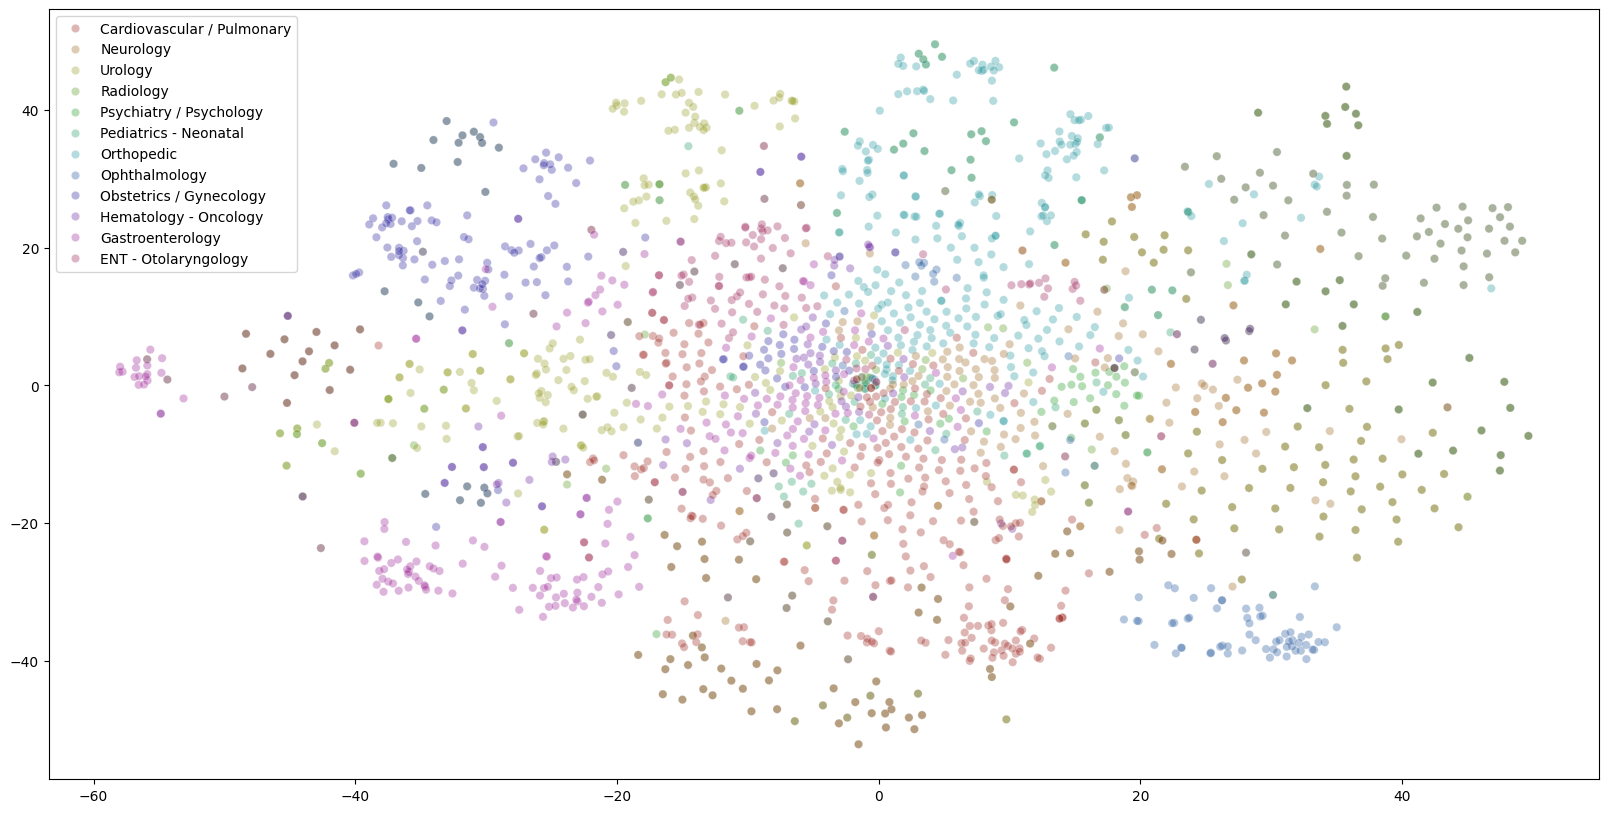

In [ ]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()

# Assuming tfIdfMatrix is your input matrix
tfIdfMatrix_array = np.asarray(tfIdfMatrix)

tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix_array)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

# logistic regression for developing a classification model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 582)
Test_Set_Size:(581, 582)


In [ ]:
#clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf = LogisticRegression(penalty= 'elasticnet',
                         solver= 'saga',
                         l1_ratio=0.5,
                         random_state=1)
clf.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

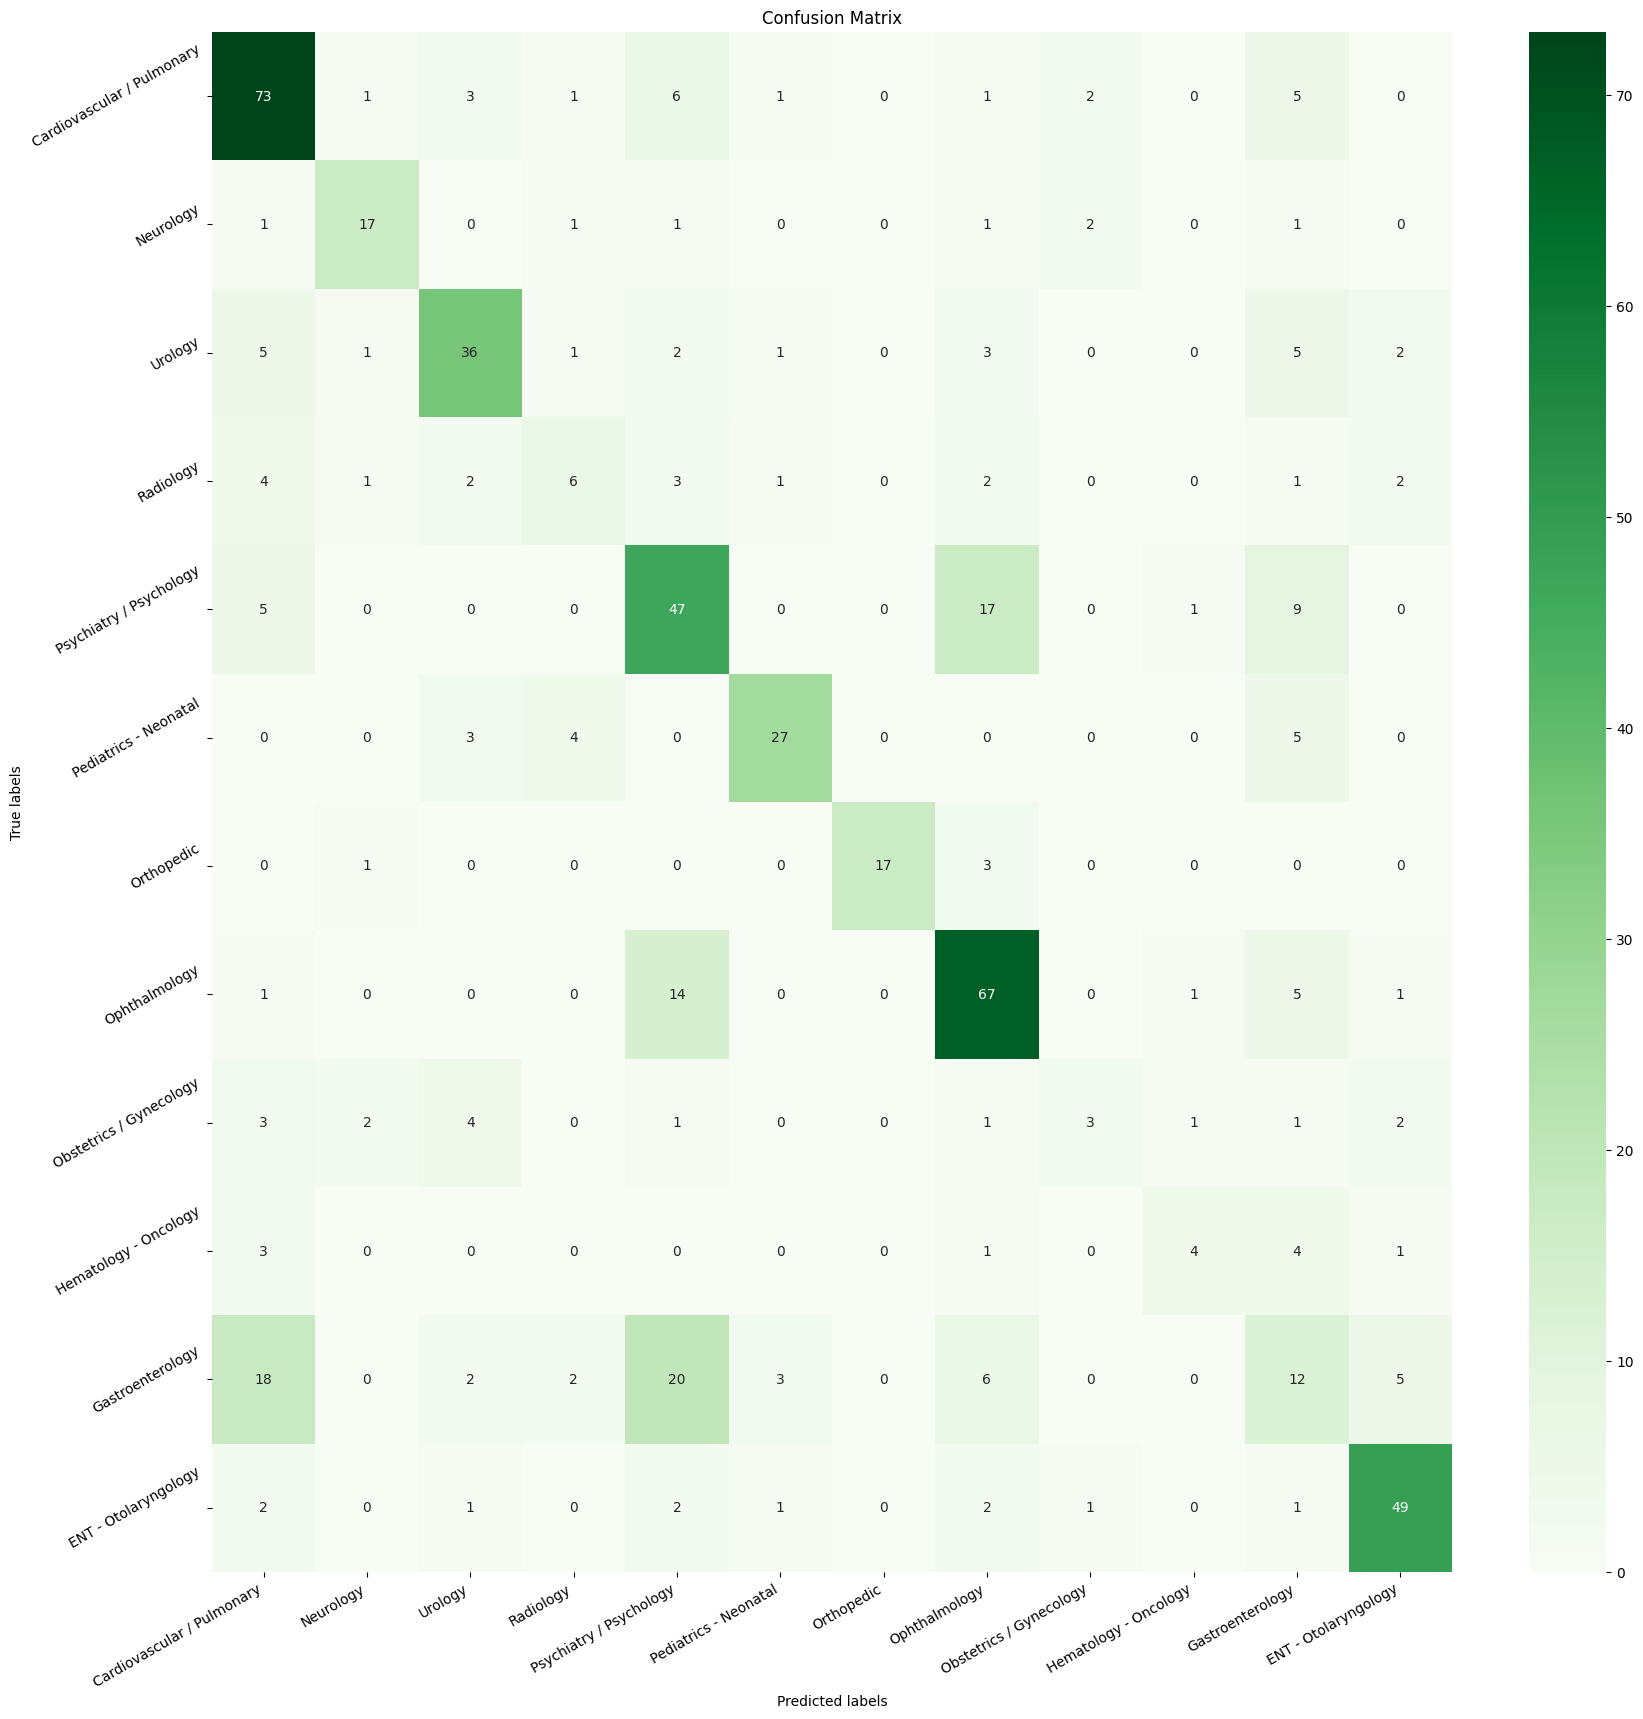

In [ ]:
labels = category_list

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a figure
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

# Plot heatmap
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Rotate tick labels
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Show the plot
plt.show()

There is marked improvement in results. Since some classes are in minority we can use SMOTE(Synthetic Minority Over-sampling Technique ) to generate more sample form minority class to solve the data imbalance problem.

Let us generate new dataset using SMOTE and then perform classification on them

In [ ]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1981, 582)
Test_Set_Size:(661, 582)


In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

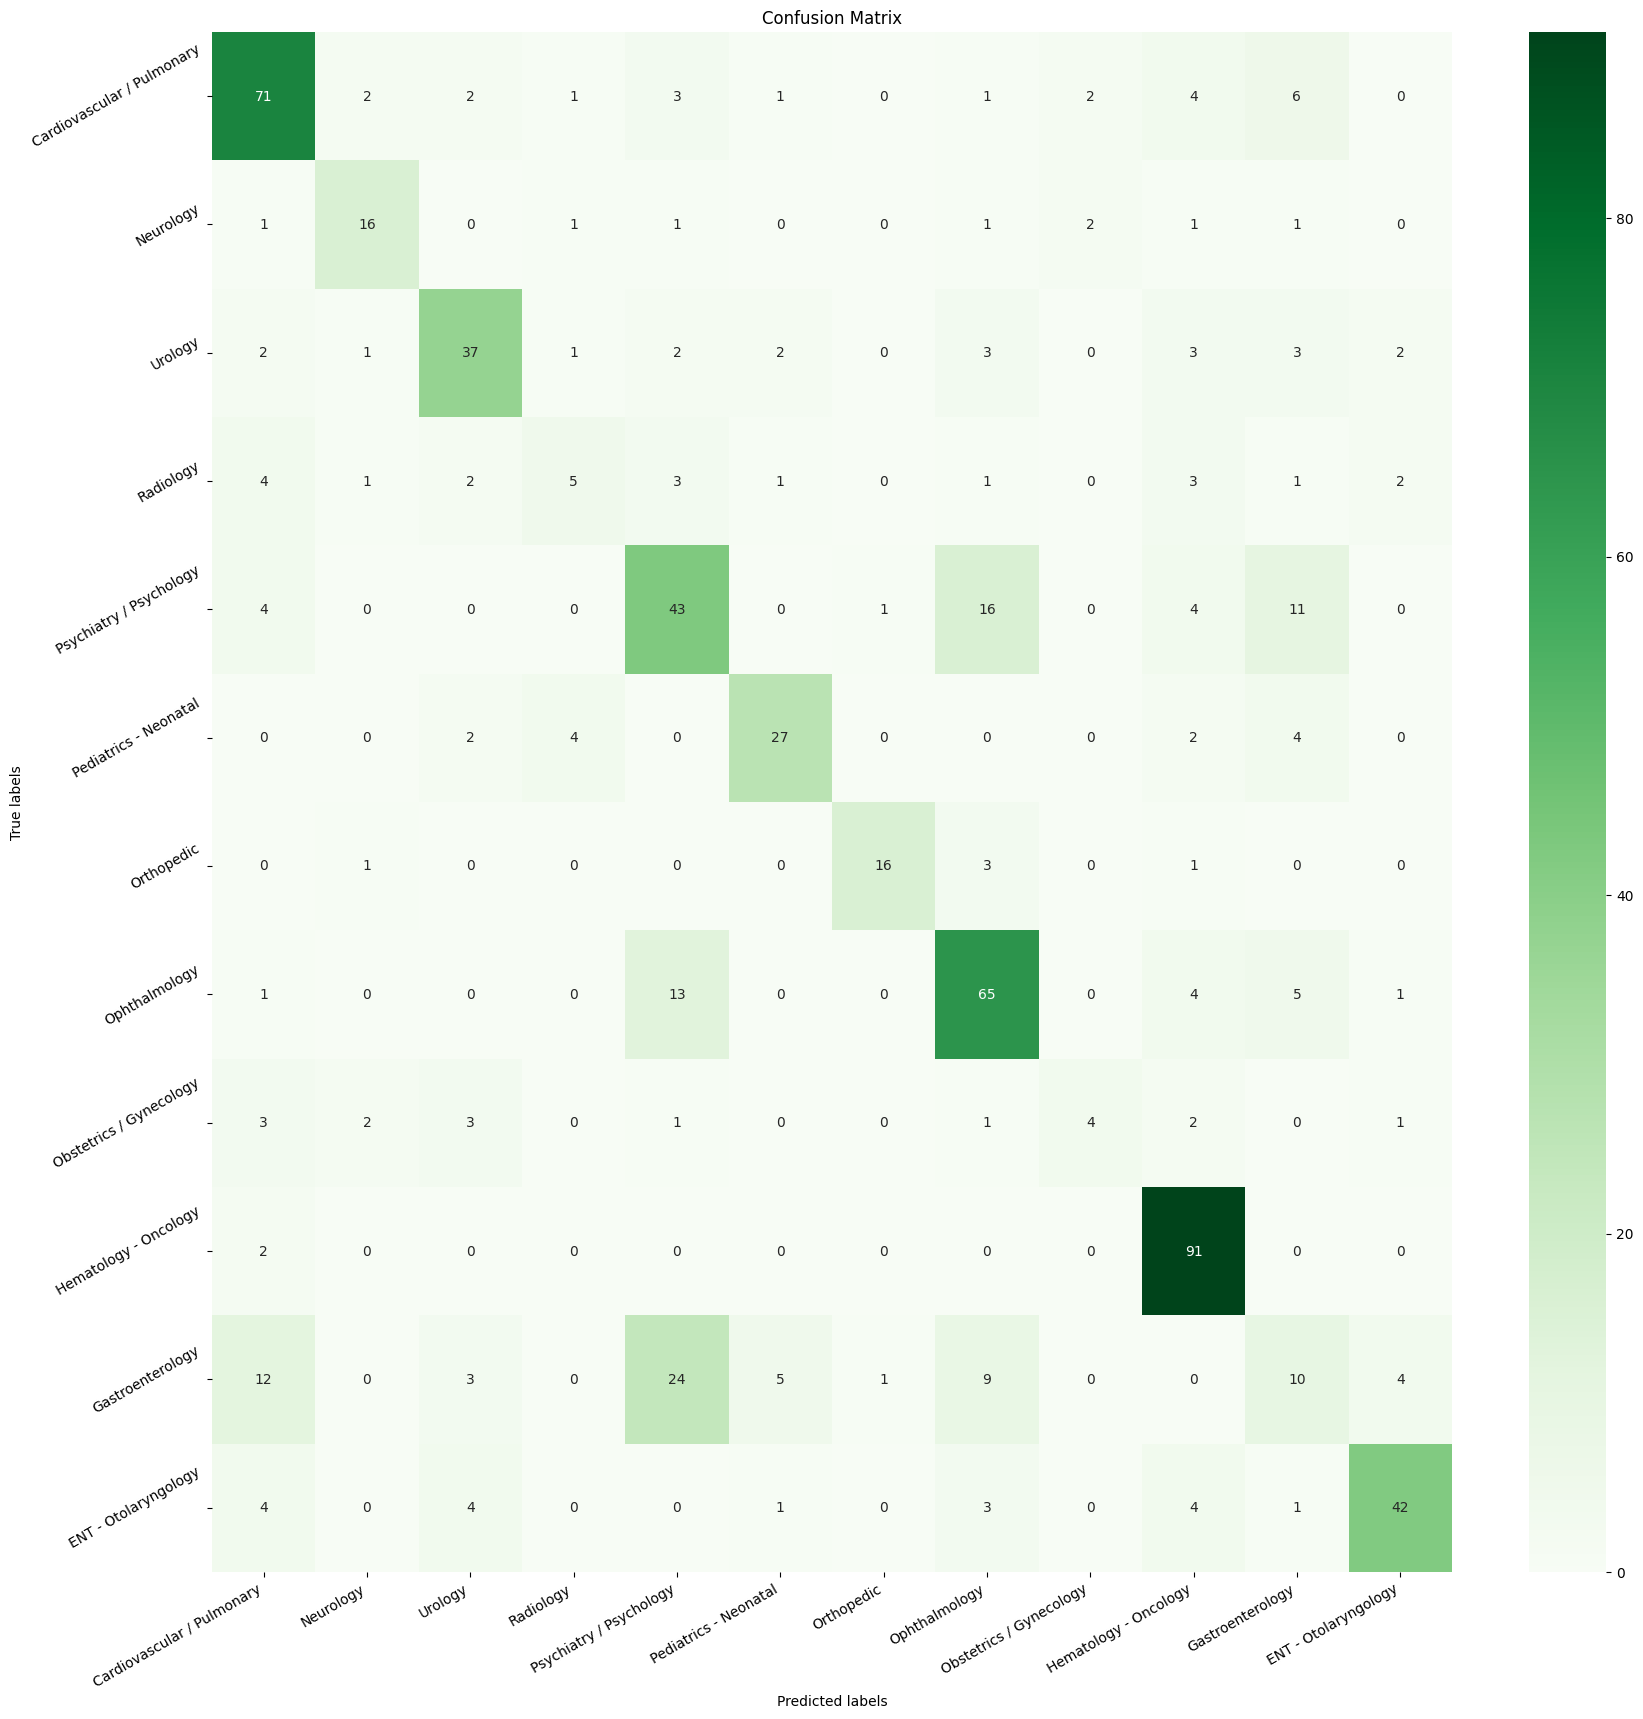

In [ ]:
labels = category_list

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a figure
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

# Plot heatmap
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Rotate tick labels
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Show the plot
plt.show()

Still some categories are not getting classofoed properly.Let us look at samples from these classes

In [ ]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [ ]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

In [ ]:
mask = clinical_text_df['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = clinical_text_df[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays

My learnings from this dataset are: This dataset is very noisy.

Lot of text in transcriptions overlaps across categories

We can apply domain knowledge to reduce the categories

It is imbalanced dataset and using SMOTE can improve the results

Hand coded features may improve results on this dataset but may not apply to generic transcription datasets.